# Восстановление золота из руды

Требуется подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.  
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.  
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Описание данных

**Данные находятся в трёх файлах:**

*gold_industry_train.csv* — обучающая выборка  
*gold_industry_test.csv* — тестовая выборка  
*gold_industry_full.csv* — исходные данные

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

**Технологический процесс**

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота.

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи.

**Наименование признаков**

Наименование признаков должно быть такое:

*[этап].[тип_параметра].[название_параметра]*

Пример: rougher.input.feed_ag

- Возможные значения для блока [этап]:
    - rougher — флотация
    - primary_cleaner — первичная очистка
    - secondary_cleaner — вторичная очистка
    - final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
    - input — параметры сырья
    - output — параметры продукта
    - state — параметры, характеризующие текущее состояние этапа
    - calculation — расчётные характеристики.

**Целевые признаки**
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

**Формула расчёта эффективности**
$$
Recowery = \frac{C*(F-T)}{F*(C-T)}
$$
где:
- C — доля золота в концентрате после флотации/очистки
- F — доля золота в сырье/концентрате до флотации/очистки
- T — доля золота в отвальных хвостах после флотации/очистки.

**Формула расчёта метрики качества**
$$
sMape = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \bar{y}_i|}{(|y_i|-|\bar{y}_i|)/2} * 100
$$

где:
- $y_i$ - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
- $\bar{y}_i$ - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
- N - Количество объектов в выборке.

**Формула расчёта итоговой метрики**
$$
Итоговое sMape = 0.25 * sMape(rougher) + 0.75 * sMape(final)
$$

# План Работ

- Подготовка данных
    -  Импорт библиотек и функции
    - Создание функций
    - Открытие файлов и изучение данных
    - Проверка правильности расчёта
    - Анализ признаков
    - Предобработка данных
- Анализ данных
    - Анализ изменения концентрация металлов Au, Ag, Pb
    - Сравнение распределения размеров гранул сырья
    - Исследование суммарной концентрации всех веществ
- Модель
    - Подготовка признаков
    - Обучение моделей
        - Модель Дерево решений
        - Модель Случайный лес
        - Модель Линейная регрессия
        - Проверка лучшей модели
- Выводы.        

## Подготовка данных

### Импорт библиотек и функции

In [1]:
# Импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

### Создание функций

In [2]:
# Создадим функцию для открытия файлов
def open_df (file_name):
    try:
        return pd.read_csv('/datasets/{}'.format(file_name), index_col='date')
    except:
        print('Не удалось открыть файл "{}!'.format(file_name))

# Создадим функцию вывода основной информацию о датафрейме
def survey_df(df):
    with pd.option_context('display.max_columns', None):
        print('Размер таблицы: {} строк, {} столбцов'. format(df.shape[0], df.shape[1]))
        display(df.head())
        print('\n', 'Дублирующихся строк:', df.duplicated().sum(), '\n')
        df.info()
        
# Создадим функцию вычисления эффективности обогащения
def output_recovery (concentrate, feed, tail):
    try:
        return ((concentrate * (feed - tail)) / (feed * (concentrate - tail)) * 100)
    except:
        print('Не удалось вычислить эффективность!')

# Создадим функцию отображения количества пропусков в датафрейме
def show_pass(df, x, y): # x и y - размер графика
    try:
        (df.isna().mean()*100).to_frame().rename(columns = {0:'space'}).query('space > 0')\
        .sort_values(by = 'space', ascending = True)\
        .plot(kind = 'barh', figsize = (x,y), legend = False, fontsize = 15)\
        .set_title('Количество пропусков в данных в %' + "\n", fontsize = 22, color = 'SteelBlue');
    except:
        print('Пропусков нет!')
    
# Создадим функцию для вычисления sMAPE
def smape(actual, forecast):
    try:
        return 1 / len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)) * 100)
    except:
        print('Не удалось вычислить sMAPE!')

# Создадим функцию для вычисления итогового sMAPE
def smape_final(actual, forecast):
    try:
        return (0.25 * smape(actual['rougher.output.recovery'], forecast[:, 0])) +\
                (0.75 * smape(actual['final.output.recovery'], forecast[:, 1]))
    except:
        print('Не удалось вычислить итоговый sMAPE!')

### Открытие файлов и изучение данных

In [3]:
# Откроем файл с обучающей выборкой и сохраним его содержимое в переменной data_train
data_train = open_df('gold_recovery_train_new.csv')

# Откроем файл с тестовой выборкой и сохраним его содержимое в переменной data_test
data_test = open_df('gold_recovery_test_new.csv')

# Откроем файл с исходными данными и сохраним его содержимое в переменной data_full
data_full = open_df('gold_recovery_full_new.csv')

In [4]:
# Выведем основную информацию о датафрейме data_train
survey_df(data_train)

Размер таблицы: 14149 строк, 86 столбцов


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.


 Дублирующихся строк: 0 

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au  

In [5]:
# Выведем основную информацию о датафрейме data_test
survey_df(data_test)

Размер таблицы: 5290 строк, 52 столбцов


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289


 Дублирующихся строк: 0 

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatban

In [6]:
# Выведем основную информацию о датафрейме data_full
survey_df(data_full)

Размер таблицы: 19439 строк, 86 столбцов


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.


 Дублирующихся строк: 0 

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au  

Данные открыты корректно. Количество записей в полном наборе данных соответствует сумме записей тренировочного и тестового наборов. В тестовом наборе на 34 столбца (признака) меньше чем в тренировочном и полном. Дублирующихся данных нет. Значения в столбцах соответствуют указанным типам данных. В данных есть пропуски.

### Проверка правильности расчёта
эффективности обогащения

In [7]:
# Вычислим MAE для посчитанных и табличных значений эффективности процесса флотации
mean_absolute_error(data_train['rougher.output.recovery'], \
                    output_recovery(data_train['rougher.output.concentrate_au'], \
                                    data_train['rougher.input.feed_au'], \
                                    data_train['rougher.output.tail_au']))

9.73512347450521e-15

Значения эффективности обогащения (флотации) посчитаны верно, средняя абсолютная ошибка MAE составляет 9.735e-15 процента.

### Анализ признаков
недоступных в тестовой выборке

In [8]:
# Посмотрим какие признаки недоступны в тестовой выборке
data_train.drop(data_test.columns, axis=1).columns.tolist()

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствуют признаки с:
- данными о содержании au, ag, pb и sol в черновом концентрате и отвальных хвостах после обогащения (флотации), и эффективность обогащения (флотации) (9 признаков)
- данными о содержании au, ag, pb и sol в концентрате и отвальных хвостах после первичной очистки (8 признаков)
- данными о содержании au, ag, pb и sol в отвальных хвостах после вторичной очистки (4 признака)
- данными о содержании au, ag, pb и sol в финальном концентрате и финальных отвальных хвостах, и финальная эффективность обогащения  (9 признаков)
- данными о расчётных характеристиках процесса флотации (4 признака)

Эти признаки являются онлайн-метриками, они доступны или рассчитываются после завершения процесса. Эти признаки могут привести к утечке целевого признака. Эффективность обогащения (флотации) и финальная эффективность обогащения являются целевыми признаками.

In [9]:
# Добавим целевые признаки в тестовую выборку в соответствии с индексом (дата и время)
# до предобработки, чтобы не потерять их
data_test = data_test.merge(data_full[['rougher.output.recovery', 'final.output.recovery']]\
                            .loc[data_test.index], on='date', how='left')
# и проверим результат
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

Целевые признаки добавлены корректно.

### Предобработка данных

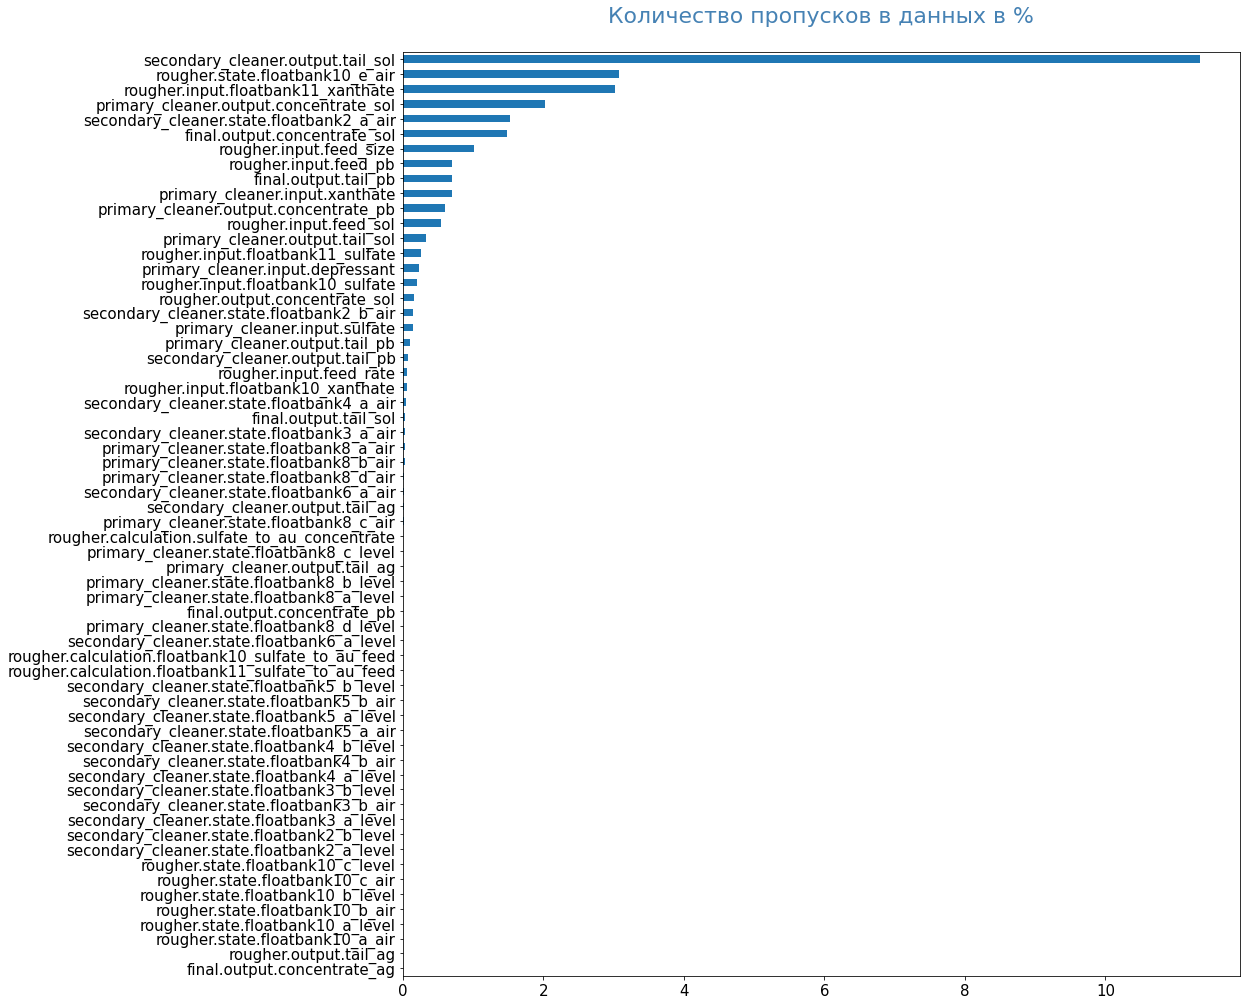

In [10]:
# Посмотрим на количество пропусков в тренировочной выборке
show_pass(data_train, 15, 17)

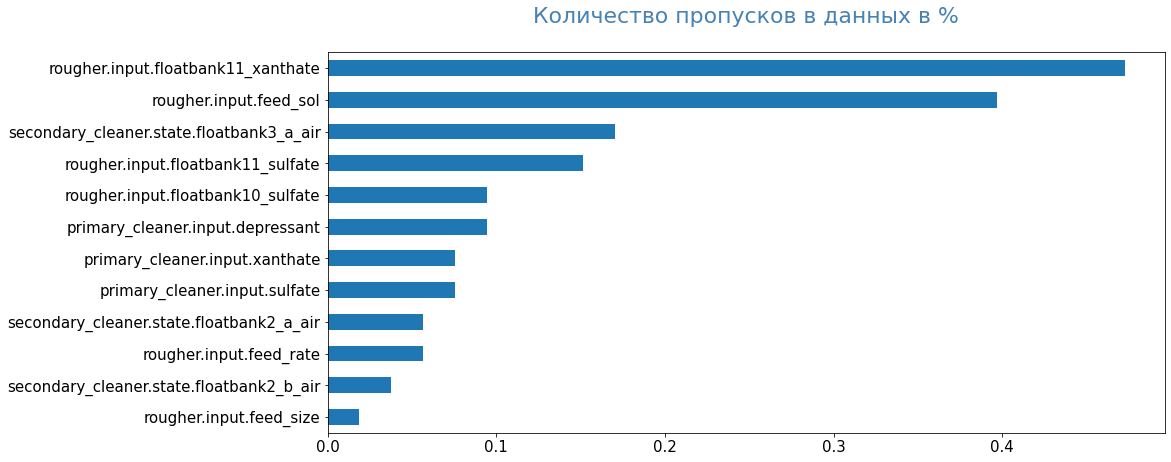

In [11]:
# Посмотрим на количество пропусков в тестовой выборке
show_pass(data_test, 15, 7)

Пропусков в целевых признаках "final.output.recovery" и "rougher.output.recovery" - нет ни в тестовой, ни в тренировочной выборках.  
В тренировочной выборке наблюдается значительное количество пропусков для "secondary_cleaner.output.tail_sol" - более 11%, но этот признак не будет участвовать в обучении и прогнозе. Доля пропусков в остальных признаках не превышает 3,5%.  
Количество пропусков в тестовой выборке не превышает 0.5%.  
Обработаем пропуски в признаках с учётом: **"Соседние по времени параметры часто похожи."**

In [12]:
# Заполним пропуски с применением метода ffill
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

# и проверим
print('Пропуски в "data_train": ', data_train.isna().values.any())
print('Пропуски в "data_test": ', data_test.isna().values.any())

Пропуски в "data_train":  False
Пропуски в "data_test":  False


Данные подготовлены к анализу:
- проверены корректность открытия файлов и типов данных
- проверено наличие дубликатов - не обнаружено
- пропуски заполнены в соответствии с условиями
- к тестовой выборке добавлены целевые признаки

## Анализ данных

### Анализ изменения концентрация металлов Au, Ag, Pb
на различных этапах очистки

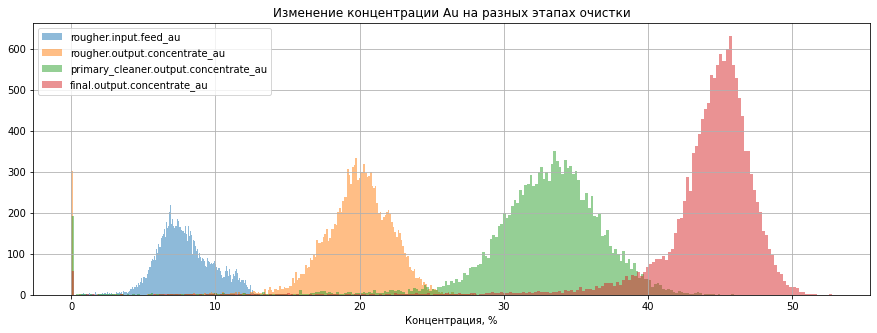

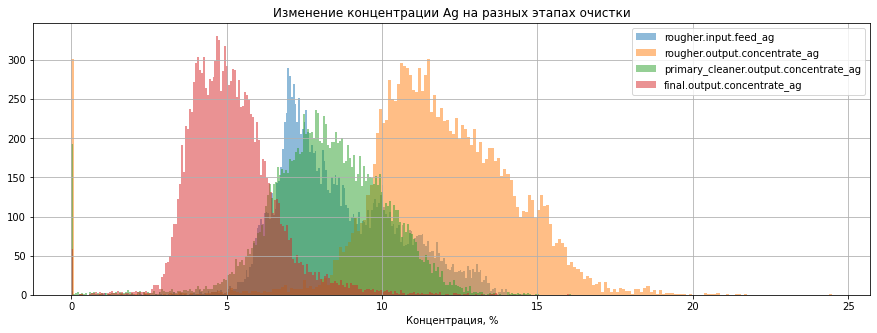

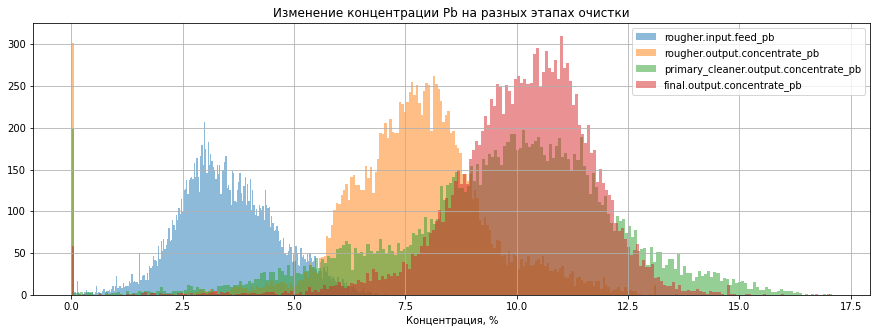

In [13]:
# Создадим словарь с исследуемыми металлами и их концентрациями на разных этапах очистки
metals = {
    'Au' : ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
            'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], 
    'Ag' : ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
            'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], 
    'Pb' : ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
            'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
}

# Построим гистограммы распределения изменения концентрации металлов на различных этапах очистки
for metall in metals:
    for stage in metals[metall]:
        data_train[stage].plot(title = 'Изменение концентрации {} на разных этапах очистки'.format(metall), 
                              kind='hist', bins=250, grid=True, legend=True, figsize=(15, 5), 
                              alpha=0.5).set(xlabel='Концентрация, %', ylabel='')
    plt.show();

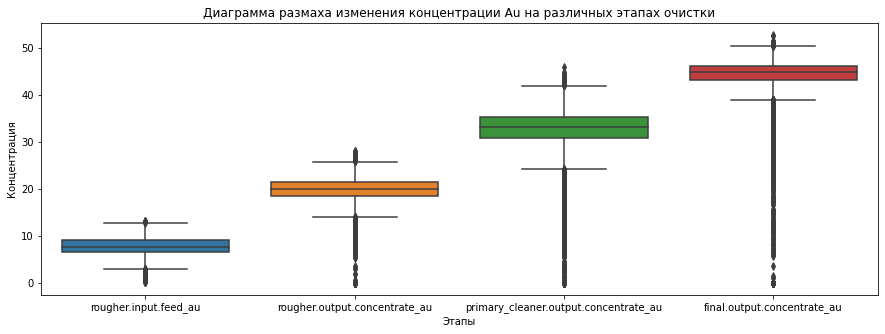

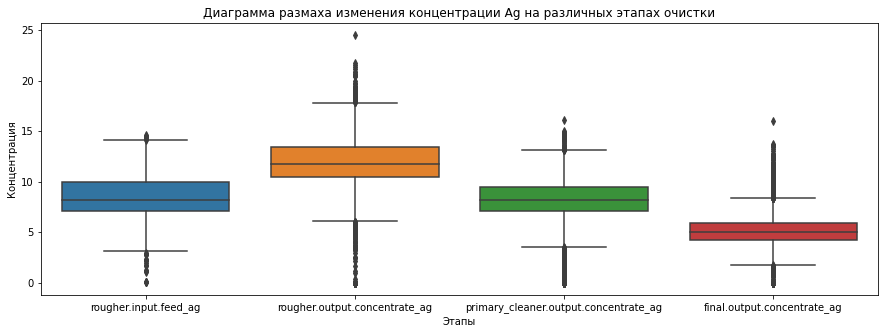

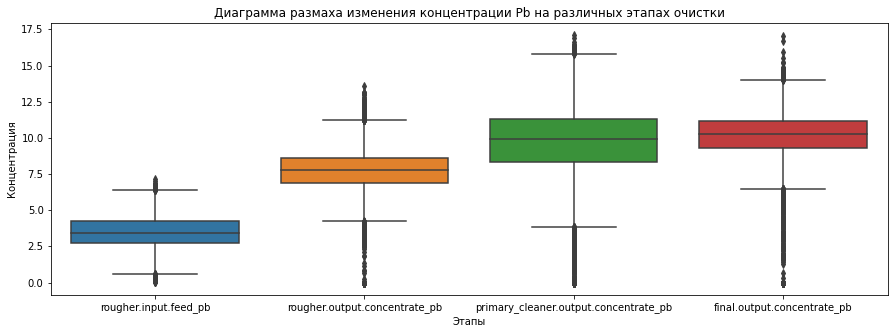

In [14]:
# Построим диаграммы размаха изменения концентрации металлов на различных этапах очистки
for metall in metals:
    sns.boxplot(data=data_train[metals[metall]])
    plt.gcf().set_size_inches(15,5)
    plt.title('Диаграмма размаха изменения концентрации {} на различных этапах очистки'.format(metall))
    plt.xlabel('Этапы')
    plt.ylabel('Концентрация')
    plt.show();

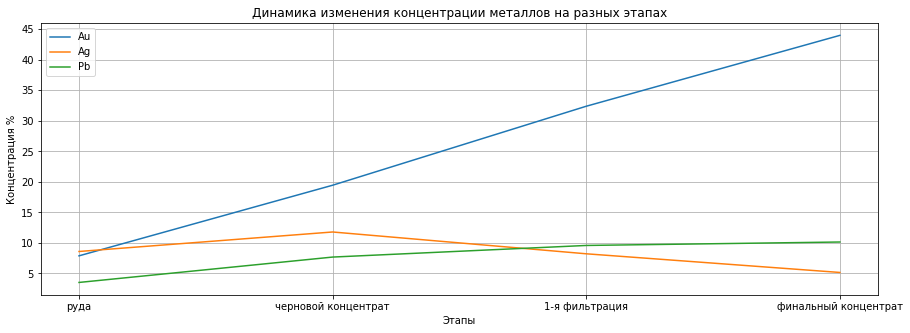

In [15]:
# Построим графики динамики изменения среднего значения концентрации металлов на разных этапах
x = ['руда', 'черновой концентрат', '1-я фильтрация', 'финальный концентрат']
for metall in metals:
    y = []
    for stage in metals[metall]:
        y.append(data_train[stage].mean())
    plt.plot(x, y, label = metall)
plt.gcf().set_size_inches(15,5)
plt.title('Динамика изменения концентрации металлов на разных этапах')
plt.xlabel('Этапы')
plt.ylabel('Концентрация %')
plt.grid()
plt.legend()
plt.show();

На графиках наблюдаем следующее:
- концентрация Au (золота) последовательно растёт и в финальном концентрате в среднем увеличивается более чем в 5 раз
- концентрация Ag (серебра) в черновом концентрате немного больше чем в руде, но в финальном концентрате она падает примерно в 1,5 раза
- концентрация Pb (свинца) в процессе обогащения последовательно увеличивается почти в 3 раза

### Сравнение распределения размеров гранул сырья
на обучающей и тестовой выборках

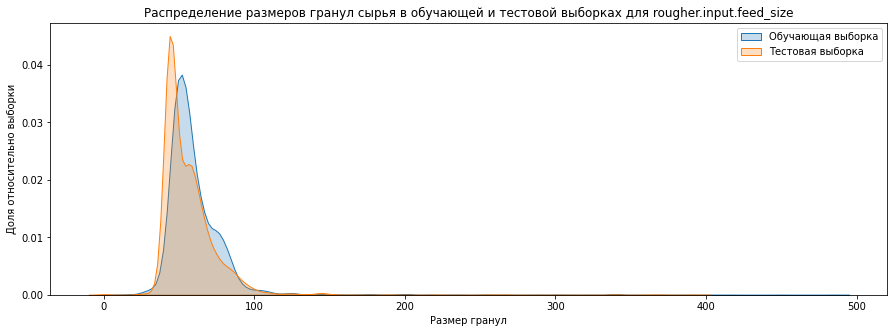

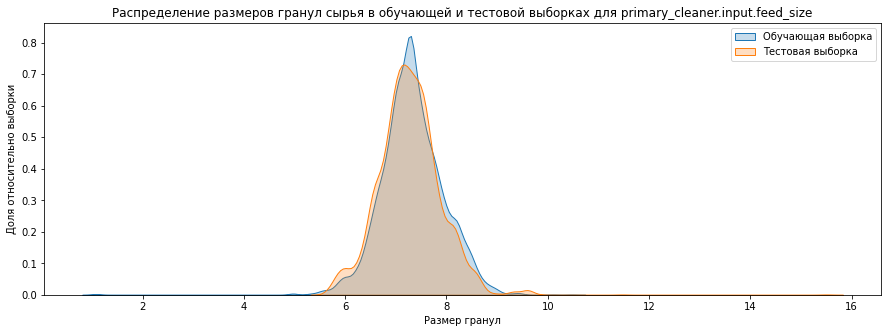

In [16]:
# Построим график плотности размеров гранул сырья в обучающей и тестовой выборках
for stage in ('rougher.input.feed_size', 'primary_cleaner.input.feed_size'):
    for label, df in (('Обучающая выборка', data_train), ('Тестовая выборка', data_test)):
        sns.kdeplot(x=stage, data=df, fill=True, label = label)
    plt.gcf().set_size_inches(15,5)
    plt.title('Распределение размеров гранул сырья в обучающей и тестовой выборках для {}'.format(stage))
    plt.xlabel('Размер гранул')
    plt.ylabel('Доля относительно выборки')
    plt.legend()
    plt.show();

Распределения размеров гранул сырья на обучающей и тестовой выборках практически идентичны, влияния на оценку модели не окажут.

### Исследование суммарной концентрации всех веществ
(Au, Ag, Pb, Sol) на разных стадиях: в сырье, в черновом и финальном концентратах.

In [17]:
# Посчитаем и сохраним значения суммарной концентрации Au, Ag, Pb и Sol на разных стадиях
mix_subst = pd.DataFrame({'руда' : data_train[['rougher.input.feed_au', 'rougher.input.feed_ag', 
                                              'rougher.input.feed_pb', 'rougher.input.feed_sol']].sum(axis=1), 
                          'черновой_концентрат' : data_train[['rougher.output.concentrate_au', 
                                                              'rougher.output.concentrate_ag', 
                                                              'rougher.output.concentrate_pb', 
                                                              'rougher.output.concentrate_sol']].sum(axis=1),
                          'финальный_концентрат' : data_train[['final.output.concentrate_au', 
                                                               'final.output.concentrate_ag', 
                                                               'final.output.concentrate_pb', 
                                                               'final.output.concentrate_sol']].sum(axis=1)
    
})
# и посмотрим основную информацию о полученых данных
survey_df(mix_subst)

Размер таблицы: 14149 строк, 3 столбцов


,руда,черновой_концентрат,финальный_концентрат
date,,,
2016-01-15 00:00:00,51.680034,66.424950,63.644396
2016-01-15 01:00:00,50.659114,67.012710,63.957723
2016-01-15 02:00:00,50.609929,66.103793,64.311180
2016-01-15 03:00:00,51.061546,65.752751,63.573449
2016-01-15 04:00:00,47.859163,65.908382,64.004667



 Дублирующихся строк: 21 

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   руда                  14149 non-null  float64
 1   черновой_концентрат   14149 non-null  float64
 2   финальный_концентрат  14149 non-null  float64
dtypes: float64(3)
memory usage: 958.2+ KB


Количество записей соответствует исходному датафрейму (data_train). В данных появились дубликаты. Они появились после заполнения пропусков с учётом условия схожести соседних по времени параметров. Проверим эту гипотезу.

In [18]:
# Посмотрим на дублирующиеся значения
mix_subst[mix_subst.duplicated()]

,руда,черновой_концентрат,финальный_концентрат
date,,,
2017-01-06 20:59:59,57.427033,72.423889,74.112068
2017-01-06 21:59:59,57.427033,72.423889,74.112068
2017-01-06 22:59:59,57.427033,72.423889,74.112068
2017-01-06 23:59:59,57.427033,72.423889,74.112068
2017-08-11 16:59:59,58.253792,41.115844,64.690452
2017-08-11 17:59:59,58.253792,41.115844,64.690452
2017-08-11 18:59:59,58.253792,41.115844,64.690452
2017-08-11 19:59:59,58.253792,41.115844,64.690452
2017-08-11 20:59:59,58.253792,41.115844,64.690452


Предположение оказалось верным: дублирующиеся записи расположены последовательно, индексы (дата и время) явно на это указывают.

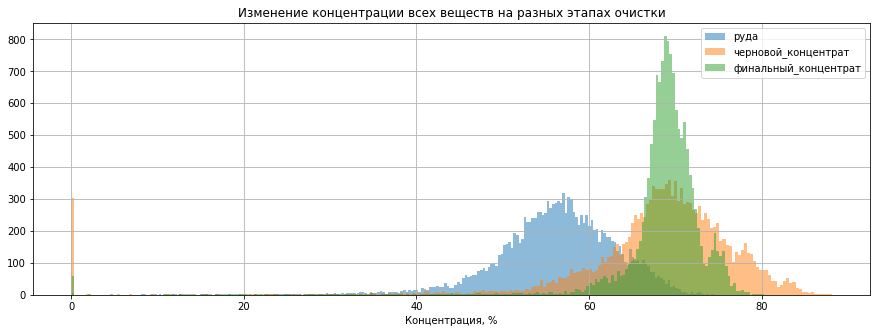

In [19]:
# Построим гистограммы распределения изменения концентрации всех веществ на различных этапах очистки
for stage in mix_subst.columns:
    mix_subst[stage].plot(title = 'Изменение концентрации всех веществ на разных этапах очистки', 
                           kind='hist', bins=250, grid=True, legend=True, figsize=(15, 5), 
                           alpha=0.5).set(xlabel='Концентрация, %', ylabel='')
plt.show();

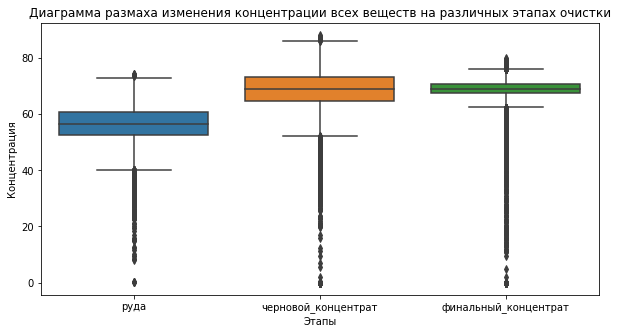

In [20]:
# Построим диаграмму размаха изменения концентрации всех веществ на различных этапах очистки
sns.boxplot(data=mix_subst)
plt.gcf().set_size_inches(10,5)
plt.title('Диаграмма размаха изменения концентрации всех веществ на различных этапах очистки')
plt.xlabel('Этапы')
plt.ylabel('Концентрация');

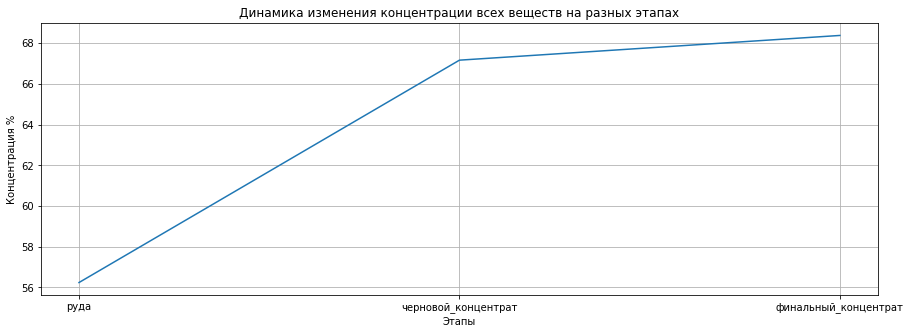

In [21]:
# Построим график динамики изменения среднего значения концентрации всех веществ на разных этапах
plt.plot(mix_subst.columns, mix_subst.mean())
plt.gcf().set_size_inches(15,5)
plt.title('Динамика изменения концентрации всех веществ на разных этапах')
plt.xlabel('Этапы')
plt.ylabel('Концентрация %')
plt.grid()
plt.show();

Средняя концентрация веществ (Au, Ag, Pb, Sol) в черновом концентрате примерно на 11% выше чем в руде, и ещё примерно 1% добавляет фильтация.  
Фильтрация уменьшает разброс концентрации веществ (Au, Ag, Pb, Sol).
На гистограммах распределений суммарных концентраций имеются аномалии - нулевое значение. Отдельно по каждому веществу такое можно допустить, но суммарно в руде хоть что-то должно быть. Избавимся от этой аномалии.

In [22]:
# Объединим тестовую выборку и данные о суммарной концентрации веществ
data_train = data_train.merge(mix_subst, on = 'date', how = 'left')

# Заменим значения суммарной концентрации = 0 на NaN
data_train[['руда', 'черновой_концентрат', 'финальный_концентрат']] = \
data_train[['руда', 'черновой_концентрат', 'финальный_концентрат']].replace(0, np.nan)

# Удалим строки с пропусками в суммарной концентрации
data_train= data_train.dropna(subset = ['руда', 'черновой_концентрат', 'финальный_концентрат'])

# Проверим результат
print(data_train.shape, '\n', data_train[['руда', 'черновой_концентрат', 'финальный_концентрат']].describe())

(13795, 89) 
                руда  черновой_концентрат  финальный_концентрат
count  13795.000000         13795.000000          13795.000000
mean      56.219933            68.610459             68.664585
std        6.989913             8.113216              5.432306
min        0.040000             0.040000              0.040000
25%       52.538724            65.248019             67.559772
50%       56.619236            69.310903             69.136193
75%       60.760588            73.508255             70.953745
max       74.458253            88.140119             80.210644


Было удалено 354 записи, или 2,5% данных содержащих нулевые значения суммарной концентрации веществ.

## Модель

### Подготовка признаков

In [23]:
# Выберем тестовые признаки
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
# Выберем тестовые целевые признаки
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]
# Приведём в соответствие признаки обучающей и тестовой выборок
features_train = data_train.drop(data_train.drop(data_test.columns, axis=1).columns.tolist() +\
                                 ['rougher.output.recovery', 'final.output.recovery'], axis=1)
# Выберем обучающие целевые признаки 
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]

# Проверим правильность подготовки поризнаков
print(' Обучающая выборка, признаки:        ', features_train.shape, '\n', 
      'Обучающая выборка, целевые признаки:', target_train.shape, '\n', 
      'Тестовая выборка, признаки:         ', features_test.shape, '\n', 
      'Тестовая выборка, целевые признаки: ', target_test.shape)

 Обучающая выборка, признаки:         (13795, 52) 
 Обучающая выборка, целевые признаки: (13795, 2) 
 Тестовая выборка, признаки:          (5290, 52) 
 Тестовая выборка, целевые признаки:  (5290, 2)


In [24]:
# Создадим "оценщика" для проверки эффективности обучения с использованием нашей функции smape_final
smape_final_scorer = make_scorer(smape_final, greater_is_better=False)

### Обучение моделей
и выбор лучшей для нашей задачи

#### Модель Дерево решений

In [25]:
# Зададим диапазон значений гиперпараметра для модели Дерево решений
param_grid = {'max_depth': range(2, 7)}

# Найдём лучшее значение гиперпараметра и оценку модели
model = DecisionTreeRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_final_scorer)
search.fit(features_train, target_train)
print('Лучшее sMAPE для модели Дерево решений: {:.2f}% при значении гиперпараметра: {}'\
      .format(-search.best_score_, search.best_params_))

Лучшее sMAPE для модели Дерево решений: 9.17% при значении гиперпараметра: {'max_depth': 3}


#### Модель Случайный лес

In [26]:
# Зададим диапазон значений гиперпараметров для модели Случайный лес
param_grid = {'max_depth': range(4, 7), 'n_estimators': range(10, 31, 10)}

# Найдём лучшее значение гиперпараметров и оценку модели
model = RandomForestRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_final_scorer)
search.fit(features_train, target_train)
print('Лучшее sMAPE для модели Случайный лес: {:.2f}% при значении гиперпараметров: {}'\
      .format(-search.best_score_, search.best_params_))

Лучшее sMAPE для модели Случайный лес: 8.76% при значении гиперпараметров: {'max_depth': 4, 'n_estimators': 30}


#### Модель Линейная регрессия

In [27]:
model = LinearRegression()
model.fit(features_train, target_train)
print('Лучшее sMAPE для модели Линейная регрессия: {:.2f}%'\
      .format(-cross_val_score(model, features_train, target_train, cv=5, scoring=smape_final_scorer).mean()))

Лучшее sMAPE для модели Линейная регрессия: 10.06%


Лучший результат sMAPE = 8.76% в нашей задаче показала молеь Случайный лес с гиперпараметрами 'max_depth' = 4, 'n_estimators' = 30. Худший результат показала модель Линейная регрессия - sMAPE = 10.06%.

#### Проверка лучшей модели
на тестовой выборке

In [28]:
# Обучим модель Случайный лес с найденными ранее значеними гиперпараметров и дадим пердсказания на тестовой выборке
model = RandomForestRegressor(max_depth=4, n_estimators=30, random_state=12345) 
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
# Вычислим и выведем значение итогового sMAPE для тестовой выборки
print('sMAPE для тестовой выборки: {:.2f}%'.format(smape_final(target_test, predict_test)))

sMAPE для тестовой выборки: 9.22%


Проверим модель на адекватность, сравним её с константной.

In [29]:
# Обучим модель DummyRegressor со стратегией "median" и дадим пердсказания на тестовой выборке
model = DummyRegressor(strategy="median") 
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
# Вычислим и выведем значение итогового sMAPE для тестовой выборки
print('sMAPE для константной модели на тестовой выборке: {:.2f}%'.format(smape_final(target_test, predict_test)))

sMAPE для константной модели на тестовой выборке: 9.44%


Константная модель предсказывает результат хуже, чем модель случайный лес, но разница весьма незначительна - 0.22%.

## Выводы:
- Входные данные имеют корректный формат, без повторов, но с пропусками. Пропусков в значениях целевого признака - нет. Пропуски в признаках заполнены в соответствии с условием - "соседние по времени параметры часто похожи". Тестовая выборка не включает в свой состав признаки, котороые доступны или расчтываются после завершения процесса, в т.ч. целевые признаки (всего 34 шт).
- Из данных в обучающей выборке видно как изменяется концентрация элементов в процессе обогащения. Концентрация золота (Au) увеличивается примерно в 5 раз, свинца (Pb) - примерно в 3 раза, при этом концентрация серебра становится примерно в 1,5 раза меньше. Суммарная концентрация веществ (Au, Ag, Pb, Sol) увеличивается примерно на 12% (с 56 до 68%), при этом уменьшается разброс значений их общей концентрации.
- Наилучший результат по метрике sMAPE показала модель Случайный лес с гиперпараметрами 'max_depth' = 5, 'n_estimators' = 30: значение для обучающей выборки 10.40%, для тестовой - 9.22%. Худший результат у модели Линейная регрессия - sMAPE для обучающей выборки 12.38%.